# Scattering Rates

Scattering rates (linewidths) can be currently computed only within the self-energy relaxation-time approximation (SERTA) using DFTBephy v.0.1. 

In this graphene example, the scattering rates for electrons are computed with the chemical potential set to 0.1 eV above the Fermi energy. The calculations are performed at room temperature.


`RelaxationTimes={}` block in the input file is as follows:

```
    RelaxationTimes = SERTA {
        qpoints = Mesh {
            npoints = 200 200 1
            refinement = 10
        }
        kpoints = Mesh {
            npoints = 16 16 1
            refinement = 20
            shift = -0.64566667 -0.32283333 0.0
        }
        Efermi [eV] = -4.6585
        mu [eV] = { 0.1 }
        sigma [eV] = 0.003
        temperature [eV] = 0.0259
   }
```

Scattering-rate calculations can be performed with [dftbephy-relaxationtimes-mpi.py](https://github.com/CoMeT4MatSci/dftbephy/blob/master/scripts/dftbephy-relaxationtimes-mpi.py) script. 

```
mpirun -np 16 python dftbephy-relaxationtimes-mpi.py |& tee -a run-scatterings.log
```

The scattering rates will be saved in `relaxation-times-fine-mpi-bandsel.hdf5`. [`Graphene-RelaxationTimes.ipynb`](https://github.com/CoMeT4MatSci/dftbephy/blob/master/notebooks/Graphene-RelaxationTimes.ipynb)can be used for plotting the inverse life-time.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import h5py

In [2]:
basedir='./'

# Relaxation Times

Along with the rates, we can also read the temperatures stored as `kBT` and chemical potentials `mus` used in the calculation, as well as the electronic structure data (`kpoints`, band energies `epsk`, and the Fermi energy `EF`). 

In [3]:
eV = 1.
Second = 1.
hbar = 6.582119569e-16 * eV * Second

datafn = basedir+'../el-ph/relaxation-times-fine-mpi-bandsel.hdf5'

with h5py.File(datafn, 'r') as f:
    sysname = f['struct'].attrs['name']

    rates = (f['el-ph']['linewidths'][()] * eV) / hbar      # to convert its units to s^{-1}
    kBTs = f['el-ph']['linewidths'].attrs['kBTs'] * eV      # room temperature, 0.0259 eV
    mus = f['el-ph']['linewidths'].attrs['mus'] * eV
    kpoints = f['el']['k-points'][()]
    epsk = f['el']['eps_kn'][()]* eV
    EF = f['el']['eps_kn'].attrs['EF']* eV

`rates[i, k, n, ν]` corresponds to the mode-resolved scattering rate for chemical potential index $i$, k-points $k$, electronic band $n$, and phonon branch $ν$. 

The shape of `rates` array can be interpreted as:

- **i=1**: number of stored chemical-potential. In this dataset only a single condition is present, $\mu= 0.1$ eV.

- **k=256**: number of **k-points**. A $16 \times 16 \times 1 $ k-point mesh contains $16 \cdot 16 \cdot 1 = 256$ points.

- **n=8**: number of included **electronic bands**.

- **$\nu$=6**: number of **phonon branches**. 


In [4]:
np.shape(rates)

(1, 256, 8, 6)

In the following, we plot the scattering rates for the conduction band, resolved into acoustic phonon contributions (i.e. TA, LA, TA+LA) as well as the total rate (sum over all phonon branches).

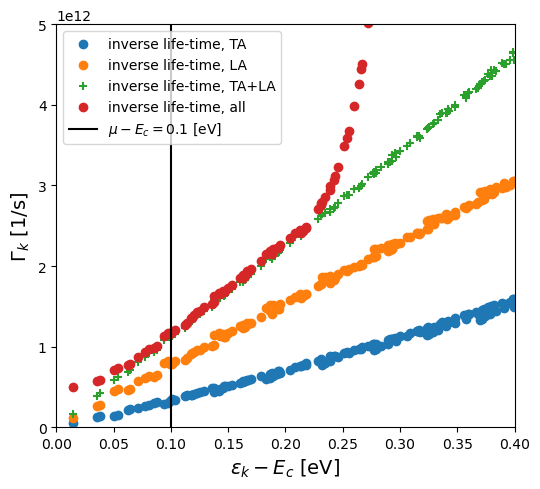

In [5]:
fig = plt.figure(figsize=(5.5,5))
ax1 = fig.add_subplot(1, 1, 1)

ax1.scatter(epsk[:,4]-EF, rates[0, :, 4, 2], label='inverse life-time, TA')
ax1.scatter(epsk[:,4]-EF, rates[0, :, 4, 1], label='inverse life-time, LA')
ax1.scatter(epsk[:,4]-EF, rates[0, :, 4, 2]+rates[0, :, 4, 1], label='inverse life-time, TA+LA', marker='+')
ax1.scatter(epsk[:,4]-EF, rates.sum(axis=3)[0, :, 4], label='inverse life-time, all')

ax1.axvline(x=mus[0]-EF, label=r'$\mu-E_c=%3.1f$ [eV]'%(mus[0]-EF), color='black')

plt.legend()
plt.xlim((0,0.4))
plt.ylim((0,0.5e13))
plt.xlabel(r'$\epsilon_k - E_c$ [eV]', fontsize=14)
plt.ylabel(r'$\Gamma_k$ [1/s]', fontsize=14)
plt.tight_layout()
plt.show()
#plt.savefig(basedir+'../Figures/graphene-scatteringrates.png)#